## Testing Unet

## Image loading

In [11]:
from data_loader import *
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

In [12]:
train_dataset = f"dataset/generated_cells"
dataset = SegmentationDataset(train_dataset)
print(f'Load images {train_dataset}: {len(dataset)} ')


img0, msk0 = dataset[0]
print('Check type and size of Torch tensor', type(img0), type(msk0))
print(f'Image[0]  {img0.shape} max: {img0.max():0.7f} max: {img0.min():0.7f} type: {img0.type()}')
print(f'Image[0]  {msk0.shape} max: {msk0.max():0.7f} max: {msk0.min():0.7f} type: {msk0.type()}')

Load images dataset/generated_cells: 100 
Check type and size of Torch tensor <class 'torch.Tensor'> <class 'torch.Tensor'>
Image[0]  torch.Size([1, 256, 256]) max: 1.0000000 max: 0.0000000 type: torch.FloatTensor
Image[0]  torch.Size([256, 256]) max: 1.0000000 max: 0.0000000 type: torch.LongTensor


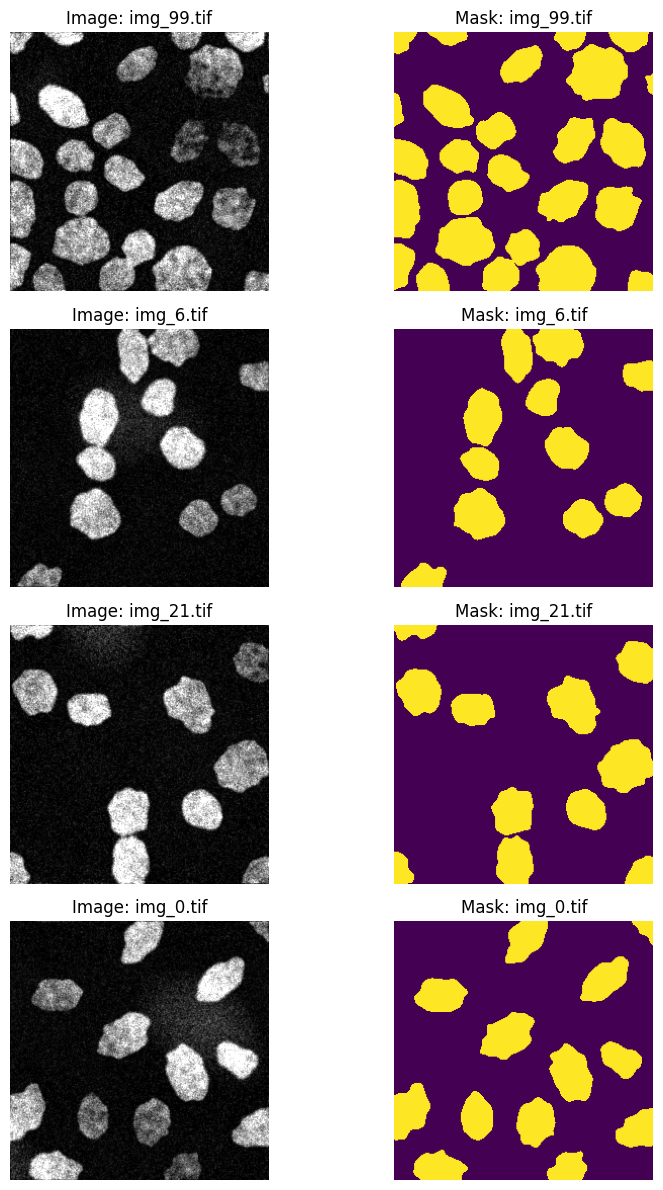

In [4]:
visualization_images(dataset, 4, 2)

In [13]:
val_ratio      = 0.25
batch_size     = 8
full_dataset = SegmentationDataset(train_dataset)
image0, mask0 = full_dataset[0]
print(type(image0))
print(f'Image 0 {image0.shape} max: {np.max(image0.shape)} {image0.type()}')
print(f'Image 0 {mask0.shape} max: {np.max(mask0.shape)} {mask0.type()}')
n_val   = max(1, int(len(full_dataset) * val_ratio))
n_train = len(full_dataset) - n_val
g = torch.Generator().manual_seed(1234)
perm = torch.randperm(len(full_dataset), generator=g).tolist()
train_dataset = Subset(full_dataset, perm[n_val:])
val_dataset   = Subset(full_dataset, perm[:n_val])

# num_workers=0 avoids PicklingError in notebooks
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Number of image in Train: {len(train_dataset)} | Val: {len(val_dataset)}")

<class 'torch.Tensor'>
Image 0 torch.Size([1, 256, 256]) max: 256 torch.FloatTensor
Image 0 torch.Size([256, 256]) max: 256 torch.LongTensor
Number of image in Train: 75 | Val: 25


In [11]:
import model
num_classes = 2
model = model.UNet(n_channels=1, n_classes=num_classes)

pretrained_model_name = "segmentation_unet.pth" 
pretrained_model_name = None 

if pretrained_model_name != None:
    ckpt = torch.load(pretrained_model_name, map_location="cpu")
    # If it was trained with DataParallel and keys start with "module.", strip the prefix:
    if isinstance(ckpt, dict) and len(ckpt) and next(iter(ckpt)).startswith("module."):
        ckpt = {k.replace("module.", "", 1): v for k, v in ckpt.items()}
    print('Checkpoints of the preload_model {pretrained_weigths}', len(ckpt))
    model.load_state_dict(ckpt, strict=True) 

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"UNet: {num_params} number of trainable parameters of model ")
print(f'Pretrained model: {pretrained_model_name}' )

UNet: 31036546 number of trainable parameters of model 
Pretrained model: None



[Fold 1]
Fold 1 | Epoch 1/10 Train Loss: 0.5178 | Val Loss: 0.6463 | IoU: 0.1122


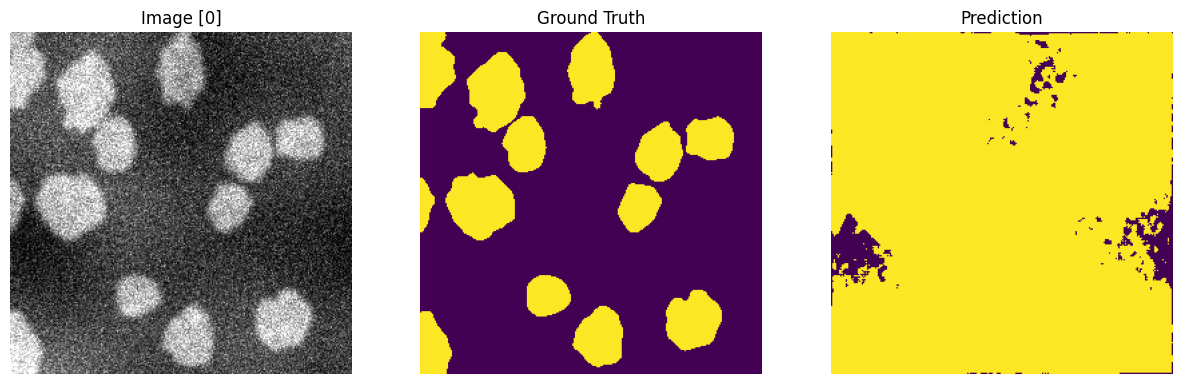

Fold 1 | Epoch 2/10 Train Loss: 0.3254 | Val Loss: 0.4932 | IoU: 0.1277


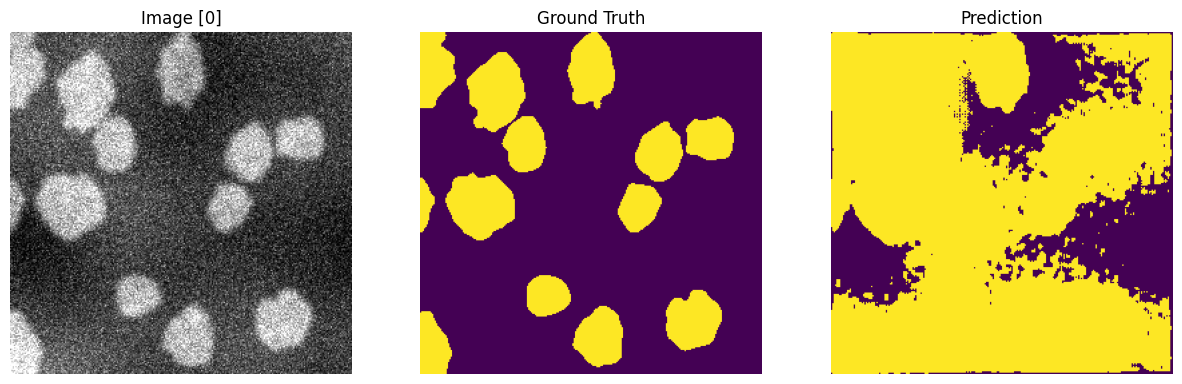

Fold 1 | Epoch 3/10 Train Loss: 0.2891 | Val Loss: 0.3943 | IoU: 0.0989


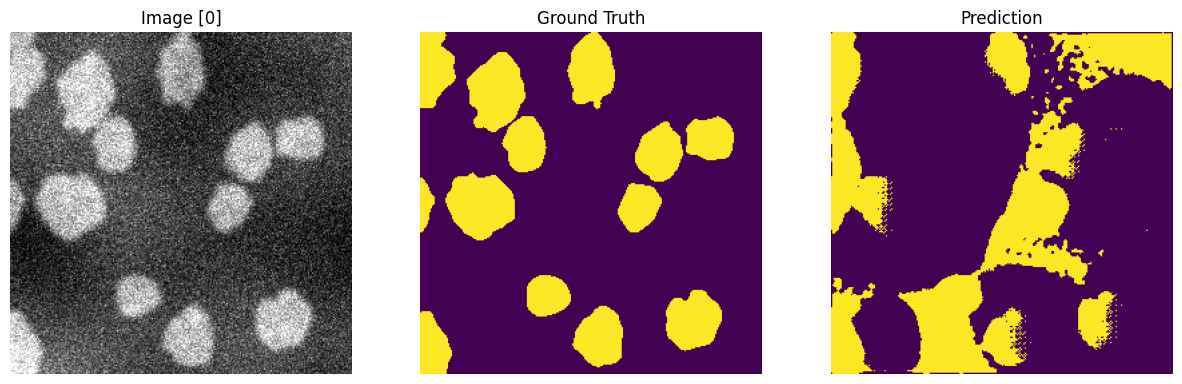

Fold 1 | Epoch 4/10 Train Loss: 0.2666 | Val Loss: 0.9581 | IoU: 0.0565


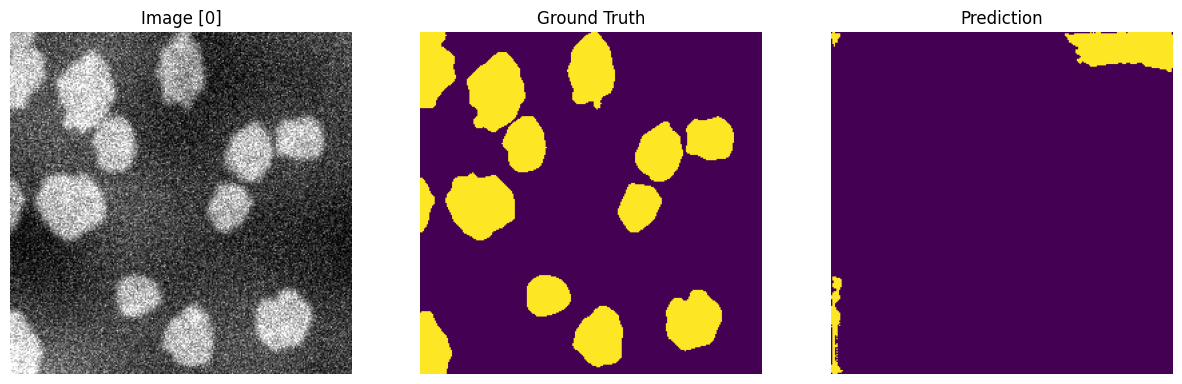

KeyboardInterrupt: 

In [8]:
import os
import numpy as np
from skimage import io, util
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from model import UNet
from sklearn.model_selection import KFold
from sklearn.metrics import jaccard_score

import matplotlib.pyplot as plt

train_dataset = f"dataset/generated_cells"
dataset = SegmentationDataset(train_dataset)
learning_rate = 1e-3
batch_size = 8
num_epochs = 10

kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold = 1
image_paths = [train_dataset + f"/images/img_{i}" for i in range(50)]


for train_index, valid_index in kf.split(image_paths):  # pass the list, not a string
    print(f"\n[Fold {fold}]")
    
    train_dataset = Subset(dataset, train_index)
    valid_dataset = Subset(dataset, valid_index)
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=8)


    model = UNet(n_channels=1, n_classes=1).to(device)
    


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    val_losses = []
    val_ious = []


    for epoch in range(num_epochs):
        model.train()
        running = 0.0

        for imgs, msks in train_loader:
            imgs, msks = imgs.to(device), msks.to(device).float()
            msks = msks.unsqueeze(1)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, msks)
            loss.backward()
            optimizer.step()

            running += loss.item() * imgs.size(0)

        tr_loss = running / len(train_dataset)
        train_losses.append(tr_loss)

        model.eval()
        val_running = 0.0
        iou_running = 0.0

        with torch.no_grad():
            for imgs, msks in valid_loader:
                imgs, msks = imgs.to(device), msks.to(device).float()
                msks = msks.unsqueeze(1)
                out = model(imgs)

                vloss = criterion(out, msks)
                val_running += vloss.item() * imgs.size(0)

                pred = torch.sigmoid(out)
                pred = (pred > 0.5).float()

                iou_running += jaccard_score(
                    msks.cpu().numpy().reshape(-1),
                    pred.cpu().numpy().reshape(-1)
                )

        va_loss = val_running / len(valid_dataset)
        va_iou = iou_running / len(valid_dataset)

        val_losses.append(va_loss)
        val_ious.append(va_iou)

        print(f"Fold {fold} | Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f} | IoU: {va_iou:.4f}")
        visualize_prediction(model, train_dataset, device, sample_idx=0)

    
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {fold} – Loss Curves")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, val_ious, label="Val IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title(f"Fold {fold} – IoU Curve")
    plt.legend()
    plt.show()

    

    fold += 1


In [9]:
def visualize_prediction(model, subset, device, sample_idx=0):
    model.eval()
    with torch.no_grad():
        img, msk = subset[sample_idx]

        # prepare input
        inp = img.unsqueeze(0).to(device)  # [1,1,H,W]
        logits = model(inp)                # [1,1,H,W]

        # convert logits → probabilities → binary mask
        prob = torch.sigmoid(logits)[0,0].cpu().numpy()    # [H,W]
        pred = (prob > 0.5).astype(np.uint8)               # [H,W]

        # get raw image
        img_show = img.squeeze(0).cpu().numpy()
        msk_show = msk.squeeze().cpu().numpy()

        # plot
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1); plt.imshow(img_show, cmap='gray'); plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(msk_show, cmap='gray'); plt.title("Ground Truth"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(pred, cmap='gray'); plt.title("Prediction"); plt.axis("off")
        plt.show()

Using device: cpu
Starting training for 100 epochs...


C:\Users\Léa\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Léa\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/100]  train_loss: 0.5026  val_loss: 0.6488  time: 393.15s


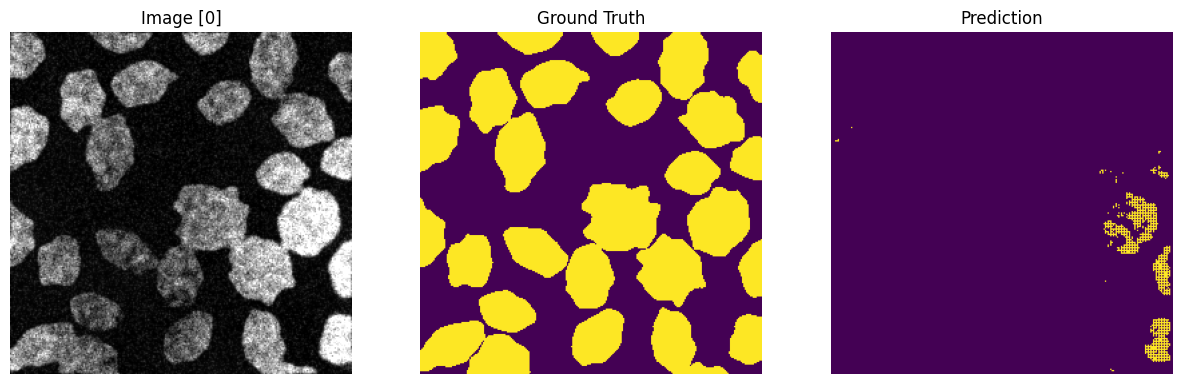

C:\Users\Léa\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Léa\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [2/100]  train_loss: 0.3107  val_loss: 0.5283  time: 442.02s


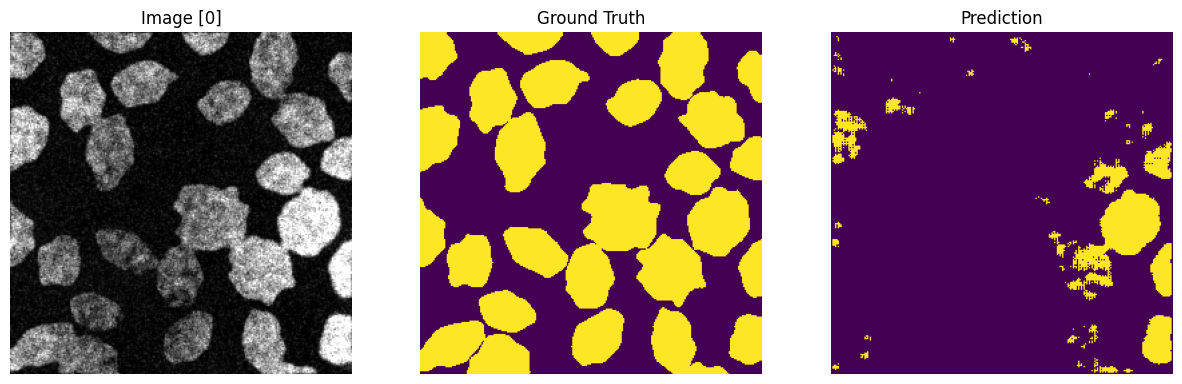

C:\Users\Léa\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
from model import UNet

num_epochs   = 100
batch_size   = 8
snapshot     = max(1, num_epochs // 10)
model = UNet(n_channels=1, n_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(f"Using device: {device}")

model.to(device)
print(f"Starting training for {num_epochs} epochs...")
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running = 0.0
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    for imgs, msks in train_loader:
        imgs, msks = imgs.to(device, non_blocking=True), msks.to(device, non_blocking=True).float()
        optimizer.zero_grad(set_to_none=True)
        msks = msks.unsqueeze(1)
        loss = criterion(model(imgs), msks)
        loss.backward()
        optimizer.step()
        running += loss.item() * imgs.size(0)
    tr_loss = running / max(1, len(train_dataset))
    train_losses.append(tr_loss)

    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for imgs, msks in val_loader:
            imgs, msks = imgs.to(device, non_blocking=True), msks.to(device, non_blocking=True).float()
            msks = msks.unsqueeze(1)
            vloss = criterion(model(imgs), msks)
            val_running += vloss.item() * imgs.size(0)
    va_loss = val_running / max(1, len(val_dataset))
    val_losses.append(va_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}]  train_loss: {tr_loss:.4f}  val_loss: {va_loss:.4f}  time: {time.time() - start_time:.2f}s")

    # ---- snapshot every N/10 epochs on the first training sample
    visualize_prediction(model, train_dataset, device, sample_idx=0)
        

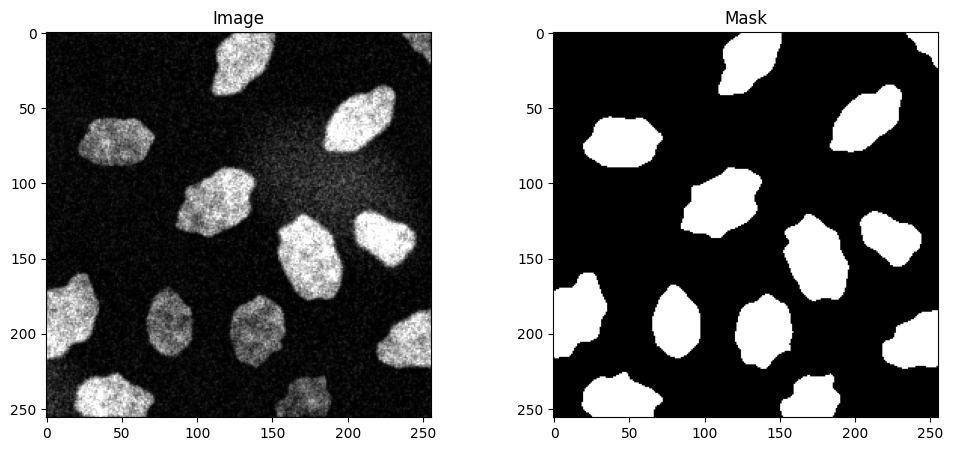

In [3]:
img, msk = dataset[0]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(img[0], cmap='gray')
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(msk, cmap='gray')
plt.show()

In [6]:
print(msk.min(), msk.max())
print(msk.unique()[:10])
print(msk.dtype)

tensor(0) tensor(1)
tensor([0, 1])
torch.int64


In [8]:
img, msk = dataset[0]
print("Image:", img.min().item(), img.max().item(), img.dtype)
print("Mask: ", msk.min().item(), msk.max().item(), msk.dtype)
print("Unique mask values:", torch.unique(msk))

Image: 0.0 1.0 torch.float32
Mask:  0 1 torch.int64
Unique mask values: tensor([0, 1])
